In [1]:
import os
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Dataset
from cv2 import imread
import matplotlib.pyplot as plt
import io

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
class StanfordDogsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.img_names = []
        self.transform = transform

        i = 0
        for file in os.listdir(self.root_dir):
            if file[-3:] == 'jpg':
                self.img_names.append(file)
            if i == 100:
                break
        # print(len(self.img_names))

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.img_names[idx])
        image = imread(img_name)
        image = image / image.max()


        if self.transform:
            image = self.transform(image)

        # print(type(image))

        return image.to(torch.float)

In [4]:
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512))
])

trainset = StanfordDogsDataset('./dataset', data_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

In [28]:
# CNN model
class HashingNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, 3, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(32, 64, 3, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 128, 3, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Flatten(1, 3),
            torch.nn.Linear(6272, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 1024),
            torch.nn.Sigmoid(),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(1024, 2048),
            torch.nn.ReLU(),
            torch.nn.Linear(2048, 6272),
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (128,7,7)),

            torch.nn.ConvTranspose2d(128, 64, 3, 2),
            torch.nn.ReLU(),
            torch.nn.Upsample(size=(31,31)),

            torch.nn.ConvTranspose2d(64, 32, 3, 2),
            torch.nn.ReLU(),

            torch.nn.Upsample(size=(127,127)),

            torch.nn.ConvTranspose2d(32, 3, 3, 2),
            torch.nn.Upsample(size=(512,512)),

            torch.nn.ReLU(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        if self.training:
            decoded = self.decoder(encoded)
            return decoded
        return encoded
        buff = io.BytesIO()
        torch.save(x, buff)
        buff.seek(0)
        return buff.read()


def train(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            optimizer.zero_grad()
            outputs = model(data)
            #print(outputs.shape)
            loss = criterion(outputs, data)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 1000 == 999:
                print(f'[{epoch + 1}, {i + 1}] loss: {running_loss / 1000}')
                running_loss = 0.0

In [29]:
train_loader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

hashNet = HashingNet()

criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(hashNet.parameters(), lr=0.001)
train(hashNet, train_loader, criterion, optimizer, epochs=3)

In [43]:
img = trainset[0]
img = img[None, :, :, :]
hashNet.eval()
hsh = hashNet(img)
print(hsh)

tensor([[0.2794, 0.2690, 0.2670,  ..., 0.2951, 0.2619, 0.3035]],
       grad_fn=<SigmoidBackward0>)


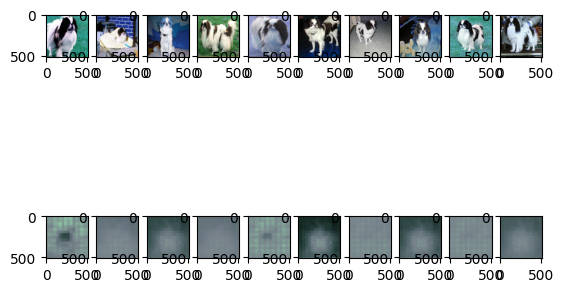

In [10]:
encoded_imgs = []
decoded_imgs = []

fig, ax = plt.subplots(2, 10)

hashNet.train()
for i in range(10):
    img = trainset[i]
    img = img[None, :, :, :]
    decoded = hashNet(img)
    decoded = torch.squeeze(decoded)
    # print(type(decoded))
    ax[0][i].imshow(trainset[i].permute(1, 2, 0))
    ax[1][i].imshow(decoded.permute(1, 2, 0).detach().numpy())

plt.show()

In [57]:
myHash = ""
hsh_norm = torch.round(hsh.squeeze() * 62 + 48).to(torch.int32)
for i in range(1024):
    let = hsh_norm[i] + 7*int(84 > hsh_norm[i] > 57) + 13*int(83 < hsh_norm[i])
    myHash += chr(let)

In [58]:
hsh_norm[0]

tensor(65, dtype=torch.int32)

In [59]:
print(chr(60))

<


In [60]:
myHash

'HHHIKFIIHJHHJIHIHFDKGJIIFIHHHEIGIIJGILHIJHIIKJGIHIIGJIIKKIIGJIJGHGGIJKGGJKIIHGGHIHHCFHHKIGJHHKGHFJIJHHJDKKHGHGGIFGIHJJJIJGGIIIHJIKEHIHJFKHGIJJIDIGHHKJIHFHJIIHHIHIJJFHJGDHFGJJIIKCIGKKIJMJEFFHIKKJFJFKIJIHIHIJJHIJLIHEGELHJIIIKHJJIIGIIJGIFIIJHFJIGIIKHHHGKIJIHHFHCJFJIHHHGKHCHFHFHHGGHIKFKIKIJIHKHIJGHGJFIHKIIHHIKIFLIFKKJGIIHJJHIHIKHHIHJEJHIJHIKJKGGGIILILHIIIGFIFLIHIGHHKGFIKGJKHIHHFEKIILKIHIHFIFGJIGIJJKHIJHGIHGHFHIHJJGIFKGFFHIIKFKGEHHHIKKHJIIHIJHHGJIGGFIHGJGIIGIJIHLFIIFKKHKFJIGHKJGHIHHMIGJJFGHIGIJKIKJFHJHHKIJHHJHGIJHKJGIHHIKHHKIIGMIJEIIIIHHGGGHHHIIHIIKIIHFIFIGIGIJJIJIHHJIIIHKHJJHGJHGJFHGHJDGJGHHKIIGIIHIGHIKIIGHHHKKFIIGEIIFIHBJIJHJKIIHFHIGKHJIHIHEGIIHIJGIIKHIIIHIJIGIIGHIJJIHFHJHIJJEJHHCHIJJKJJGILJIEJHHKJHGHHHGILJHIGKIJHIIFGIIIGFHHJHIJIIIIJGGJJFIILKHHIFIILHJIJGHIIGJJHJGIJIHHIGHJIKLIFIHFJHJKJGHIJIJGHCIIGGEHHIIJFGHGGFJIHIIJJJFHGJIKHEHGIGJHKKJJGHJFJJIGIKGIEHIIJHHKEGGHHJGJJGKIGIIEGHICIGIHGKIIFFKHGFHHHHIIIGIJHJGIEIJDIIHIHFIHJGIIIGIIFHFHHIKJIHGJHHEJJJIIGKHIIGHIJGHHIHIIIJHKHFKHGJIILGGFHIGHIIIIEHHDGIHH